## A Bayesian regularized artificial neural network for stock market forecasting

### Setup

In [126]:
import yfinance as yf 
from ta.momentum import rsi, williams_r, stoch

import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt 

from rich.table import Table
import rich 

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing._data import MinMaxScaler

In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.modules.container import Sequential
from torch import Tensor
from torchsummary import summary

import torchbnn

In [128]:
from pandas.core.series import Series
from pandas.core.frame import DataFrame
from pandas.core.groupby.generic import DataFrameGroupBy

from typing import Tuple, List

from dataclasses import dataclass

### Financial Data

In [129]:
def add_target(df: DataFrame) -> DataFrame: 
    """Description. Add t+1 closing prices."""

    df.loc[:, "Close+1"] = df["Close"].shift(1)
    return df 

In [236]:
def train_test_split(df: DataFrame, train_prop: float, target_name: str="Close+1") -> Tuple: 
    """Description. 
    Split data into training / test sets and return test period."""
    n = df.shape[0]
    train_idxs = [i for i in range(int(train_prop * n))]

    df_train = df.iloc[train_idxs, :]
    df_test = df.drop(df.iloc[train_idxs, :].index.tolist())

    test_period = (df_test.index.min().strftime("%Y-%m-%d"), df_test.index.max().strftime("%Y-%m-%d"))

    return df_train, df_test, test_period

In [131]:
def calc_ema(close: Series, n_days: int) -> Tuple: 
    """Description. 
    Return exponential moving average and variable name."""
    
    var_name = f"EMA{n_days}"
    ema = close.ewm(span=n_days).mean()

    return var_name, ema

def add_indicators(df: DataFrame, ema_n_days: List, d_period: int) -> DataFrame: 
    """Description. 
    Add multiple financial indicators: EMA, RSI, William"s R, Stochastic K%, Stochastic D%. 

    Attributes: 
        - df: initial data set
        - ema_n_days: window size for exponential moving average
        - d_period: window size for stochastic D%.

    Returns: transformed data set.
    """

    for n in ema_n_days: 
        ema_var_name, emas = calc_ema(df["Close"], n)
        df.loc[:, ema_var_name] = emas

    df.loc[:, "RSI"] = rsi(df["Close"])

    df.loc[:, "WILLIAMS_R"] = williams_r(df["High"], df["Low"], df["Close"])

    df.loc[:, "%K"] = stoch(df["High"], df["Low"], df["Close"])
    df.loc[:, "%D"] = df["%K"].rolling(d_period).mean()

    return df.dropna(axis=0)

In [132]:
def select_features(df: DataFrame, target_name: str) -> DataFrame: 
      """Description. Select Open, Low, High and technical indicators."""

      to_remove = ["Close", "Adj Close", "Volume", target_name]
      return df.drop(labels=to_remove, axis=1)   

def normalize(X: np.ndarray, scaler: MinMaxScaler, fit: bool=False) -> Tensor: 
    """Description. Scaled numpy array between -1 and 1 and return Tensor."""
    if fit:
      scaler.fit(X)

    X_scaled = Tensor(scaler.transform(X)) 

    return X_scaled

In [237]:
@dataclass 
class Data: 
    """Description. 
    Financial data object to use as input in the Bayesian NN.
    
    Attributes: 
        - ticker: stock ticker
        - start_date: beginning of observation
        - end_date: end of observation 
        - batch_size: size of each training/validation batch
        - train_prop: proportion of training examples
        - ema_n_days: parameter of exponential moving average
        - d_period: parameter for stochastic %D
        - target_name: name of the target variable

    Returns: object of type Data with multiple properties."""

    ticker: str
    start_date: str
    end_date: str 
    batch_size: int
    train_prop: float
    ema_n_days: List
    d_period: int
    target_name: str="Close+1"

    def __post_init__(self): 
        self.df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        
        self._preprocess()

        self._scaler_X = MinMaxScaler(feature_range=(-1, 1))
        self.scaler_y = MinMaxScaler(feature_range=(-1, 1))

        self._X_train = select_features(self._df_train, self.target_name)
        self.X_test = select_features(self._df_test, self.target_name)

        self._X_train = normalize(self._X_train.values, self._scaler_X, fit=True)
        self.X_test = normalize(self.X_test.values, self._scaler_X)
        
        self._y_train = self._df_train.loc[:, self.target_name].values.reshape(-1, 1)
        self.y_test = self._df_test.loc[:, self.target_name].values.reshape(-1, 1)

        self._y_train = Tensor(normalize(self._y_train, self.scaler_y, fit=True))
        self.y_test = Tensor(normalize(self.y_test, self.scaler_y))

        self._to_batches()

    def _preprocess(self): 
        """Description. Apply preprocessing steps to original data."""
        
        self.df = add_target(self.df)
        df_train, df_test, self.test_period = train_test_split(self.df, self.train_prop)

        self._df_train = add_indicators(df_train, self.ema_n_days, self.d_period)
        self._df_test = add_indicators(df_test, self.ema_n_days, self.d_period)  

    def _to_batches(self): 
        """Description. Make batches of length window size out of features and targets."""

        def _make_loader(X: Tensor, y: Tensor) -> List: 
            features, targets = torch.split(X, self.batch_size), torch.split(y, self.batch_size)
            return [(f, t) for f, t in zip(features, targets)]

        self.trainloader = _make_loader(self._X_train, self._y_train)

In [238]:
ticker = "MSFT"

start_date = "2010-01-04"
end_date = "2012-12-31"
window_size = 30

train_prop = .8
ema_n_days = [5, 10] 
d_period = 3

data = Data(ticker, start_date, end_date, window_size, train_prop, ema_n_days, d_period)
print(data)

[*********************100%***********************]  1 of 1 completed
Data(ticker='MSFT', start_date='2010-01-04', end_date='2012-12-31', batch_size=30, train_prop=0.8, ema_n_days=[5, 10], d_period=3, target_name='Close+1')


c:\Users\pemma\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


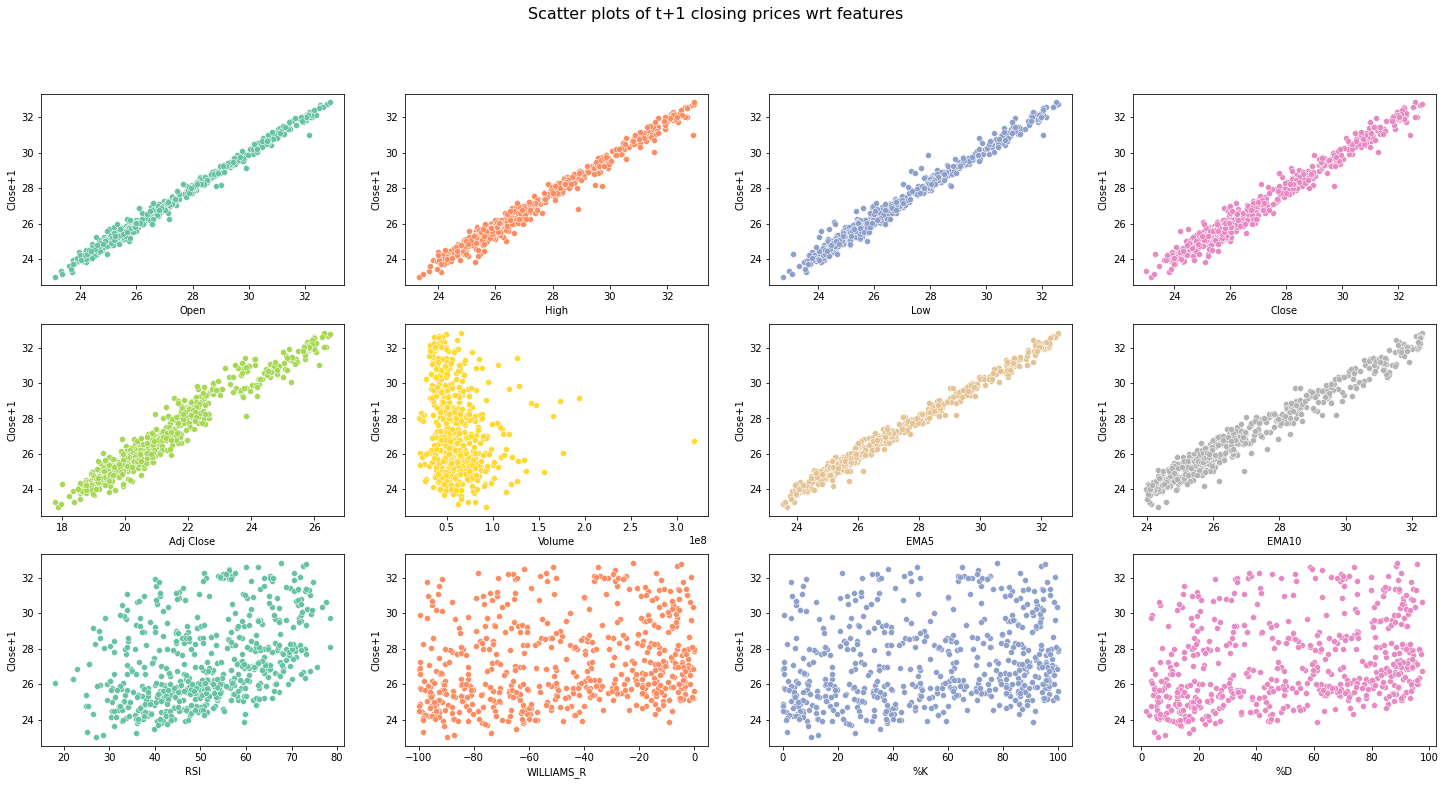

In [174]:
id_vars = data._df_train.columns.drop(labels="Close+1").tolist()

ncols = 4
if len(id_vars) % ncols == 0: 
    nrows = len(id_vars) // ncols
else: 
    nrows = len(id_vars) // ncols + 1

colors = sns.color_palette("Set2", n_colors=len(id_vars)) 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 12))
fig.suptitle("Scatter plots of t+1 closing prices wrt features", size=16)

for var, ax, c in zip(id_vars, axes.flatten(), colors):
    sns.scatterplot(data=data._df_train, x=var, y="Close+1", color=c, ax=ax); 

### Bayesian MLP

In [341]:
def ssw_loss(model) -> Tensor: 
    """Description. 
    Compute sum of squared weights using l2 norm."""

    squared = torch.tensor([p.norm(2)**2 for p in model.parameters()]) 

    return torch.sum(squared)

def sse_loss(output: Tensor, target: Tensor) -> Tensor: 
    """Description. Compute sum of squared errors."""

    return torch.sum((output - target)**2)

def mape_loss(output: Tensor, target: Tensor) -> float: 
    """Description. Mean Absolute Percentage Error."""

    if not isinstance(output, Tensor): 
        output = torch.tensor(output)
    if not isinstance(target, Tensor): 
        target = torch.tensor(target)

    return torch.mean(torch.abs(output - target)).item()

class WeightedLoss(nn.Module):
    """Description. 
    Implement custom loss as weighted combination of sum of squared errors (SSE) and sum squared weights (SSW)."""

    def __init__(self, alpha: float, beta: float, optimize: bool=False):
        super(WeightedLoss, self).__init__()
        self.optimize = optimize

        if self.optimize: 
            self.alpha = torch.nn.Parameter(torch.tensor(alpha, requires_grad=True))
            self.beta = torch.nn.Parameter(torch.tensor(beta, requires_grad=True))
        else: 
            self.alpha = torch.tensor(alpha) 
            self.beta = torch.tensor(beta) 

    def forward(self, model, output: Tensor, target: Tensor) -> Tensor: 
        """Description. Apply weighted loss function as forward pass."""
                
        ssw = ssw_loss(model)
        sse = sse_loss(output, target)

        if self.optimize: 
            loss = torch.sigmoid(self.alpha) * ssw + torch.sigmoid(self.beta) * sse
        else: 
            loss = self.alpha * ssw + self.beta * sse

        return loss

In [365]:
def train(model, trainloader: List, criterion, optimizer, epoch: int, num_epochs: int) -> List:
    """Description. Train sequential Bayesian NN. 
    
    Attributes: 
        - model: Bayesian NN
        - trainloader: list of training batches with features and closing prices
        - optimizer: algorithm used to update weights
        - criterion: loss function 
        - epoch: running epoch
        - num_epochs: total number of epochs
        
    Returns: weighted loss values."""

    model.train()
    
    loop = tqdm(trainloader)
    loop.set_description(f"Training Epoch [{epoch + 1}/{num_epochs}]")

    loss_values = []
    
    for features, target in loop:

        def closure() -> Tensor: 
            optimizer.zero_grad()
            output = model(features) 
            
            if isinstance(criterion, WeightedLoss): 
                loss = criterion(model, output, target)   
            else: 
                loss = criterion(output, target)

            loss.backward()     
            return loss

        loss = closure()
        optimizer.step(closure) 

        loop.set_postfix(train_loss=(loss.item()))

        loss_values.append(loss.item())

    return loss_values  

#### Instantiate model

In [366]:
def generate_bnn_summary(bnn_model) -> Table: 
    """Description. Return bayesian NN summary as rich Table."""
 
    table = Table(title="Bayesian NN architecture", show_lines=True)

    table.add_column("Layer (type)", justify="left")
    table.add_column("Distrbution params", justify="left")
    table.add_column("Tensors", justify="left")
    table.add_column("Param #", justify="left")

    for ix, layer in enumerate(bnn_model): 

        params = layer.__dict__["_parameters"]
        if len(params) == 0: 
            param_names = " "
        else: 
            param_names = " | ".join(list(params.keys()))

        sizes = [p.size() for p in params.values()]
        n_params = np.sum([np.prod(s) for s in sizes]) 

        sizes = " | ".join([str(s) for s in sizes])

        table.add_row(str(layer), param_names, sizes, str(n_params)) 
    
    return table 

In [367]:
def reset_all_weights(model) -> None:
    """Description. 
    Reset all weights in a sequential network."""

    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    model.apply(fn=weight_reset)

#### Training and validation

In [388]:
input_size = 9 
hidden_size = 5 
output_size = 1

model = nn.Sequential(
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=input_size, out_features=hidden_size),
    nn.Tanh(),
    torchbnn.BayesLinear(prior_mu=0, prior_sigma=.1, in_features=hidden_size, out_features=output_size)
)

print(model)

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=9, out_features=5, bias=True)
  (1): Tanh()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=5, out_features=1, bias=True)
)


In [389]:
summary = generate_bnn_summary(model)
rich.print(summary)

                                  Bayesian NN architecture                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)             ┃ Distrbution params        ┃ Tensors                  ┃ Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([5, 9]) |     │ 100     │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([5, 9]) |     │         │
│ in_features=9,           │ bias_mu | bias_log_sigma  │ torch.Size([5]) |        │         │
│ out_features=5,          │                           │ torch.Size([5])          │         │
│ bias=True)               │                           │                          │         │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ Tanh()                   │                           │                          │ 0.0     │
├──────────────────────────┼───────────────────────────┼──────────────────────────┼─────────┤
│ BayesLinear(prior_mu=0,  │ weight_mu |               │ torch.Size([1, 5]) |     │ 12      │
│ prior_sigma=0.1,         │ weight_log_sigma |        │ torch.Size([1, 5]) |     │         │
│ in_features=5,           │ bias_mu | bias_log_sigma  │ torch.Size([1]) |        │         │
│ out_features=1,          │                           │ torch.Size([1])          │         │
│ bias=True)               │                           │                          │         │
└──────────────────────────┴───────────────────────────┴──────────────────────────┴─────────┘

In [390]:
criterion = WeightedLoss(alpha=.5, beta=.5, optimize=True)

In [391]:
lr = .01
params = list(model.parameters()) + list(criterion.parameters()) 
optimizer = torch.optim.Adam(params=params, lr=lr)
print(optimizer) 

num_epochs = 100

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [392]:
results = {"epoch": [], "avg_weighted_loss": []}

for epoch in range(num_epochs): 
    mse_loses = train(model, data.trainloader, criterion, optimizer, epoch, num_epochs)

    results["epoch"].append(epoch)
    results["avg_weighted_loss"].append(np.mean(mse_loses)) 

Training Epoch [100/100]: 100%|██████████| 20/20 [00:00<00:00, 173.91it/s, train_loss=1.46]


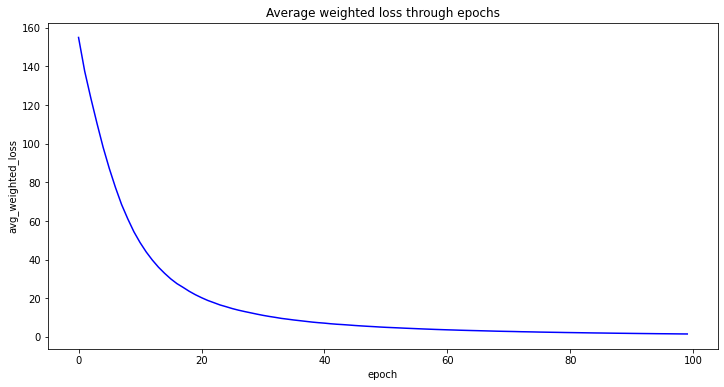

In [393]:
df_plot = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=df_plot, x="epoch", y="avg_weighted_loss", color="blue", ax=ax)

ax.set_title("Average weighted loss through epochs"); 

#### Backtest (unseen data)

In [394]:
def create_backtest_dataset(model: Sequential, data: Data) -> Tuple: 
    """Description. 
    Return pandas DataFrame with days, actual, predicted values as columns and test MAPE."""

    n = len(data.y_test)
    preds = data.scaler_y.inverse_transform(model(data.X_test).detach().numpy()) 
    y_test = data.scaler_y.inverse_transform(data.y_test)

    df_backtest = pd.DataFrame(data={
        "Days": [i for i in range(n)], 
        "Model": preds.reshape(-1,), 
        "Actual": y_test.reshape(-1, )
    })

    test_mape = round(100 * mape_loss(preds, y_test), 2) 

    return df_backtest, test_mape

In [395]:
df_backtest, test_mape = create_backtest_dataset(model, data)

In [396]:
def backtest_plot(
    df_backtest: DataFrame, 
    mape: float, 
    test_period: str,
    plot_dims: Tuple=(17, 6)): 
    """Description. 
    Visualize model"s performance: actual vs predicted prices & MAPE."""

    start_date, end_date = test_period

    fig, axes = plt.subplots(ncols=2, figsize=plot_dims)
    fig.suptitle(f"{ticker} closing prices between {start_date} and {end_date} (test data set)\nMAPE={mape}%", size=14)

    sns.lineplot(data=df_backtest, x="Days", y="Model", label="Model", ax=axes[0])
    sns.lineplot(data=df_backtest, x="Days", y="Actual", label="Actual", ax=axes[0])

    axes[0].set_xlim([0, df_backtest.shape[0]])
    axes[0].set_ylabel("$")
    axes[0].set_title("Evolution of actual & predicted values")

    sns.scatterplot(
        data=df_backtest, 
        x="Actual", 
        y="Model", 
        color="black", 
        alpha=.5,
        marker="+", 
        ax=axes[1])

    x_start = df_backtest["Actual"].min()
    x_end = df_backtest["Actual"].max()
    sns.lineplot(
        x=[x_start, x_end], 
        y=[x_start, x_end], 
        color="black", 
        linestyle="dotted", 
        label="y=x")

    axes[1].set_xlim([x_start, x_end])
    axes[1].set_title("Predicted VS actual")

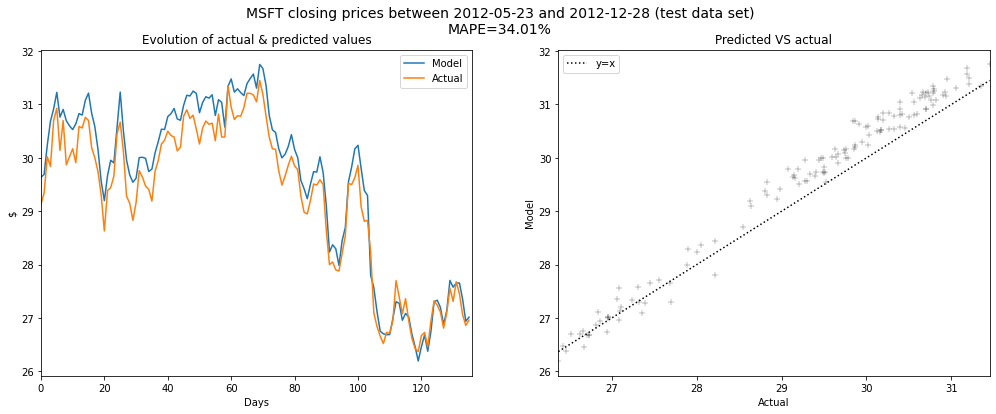

In [397]:
backtest_plot(df_backtest, test_mape, data.test_period)